# Introduction
The goal of this notebook is to answer the following questions (MC = Martinotti cell):
1. Distribution of all tagged MCs?
1. 

In [113]:
import sys
if "../.." not in sys.path: sys.path.insert(0, "../..")
if ".." not in sys.path: sys.path.insert(0, "..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

from experiment.v1dd_em_client import V1DDEMClient
import analysis_tools as at
at.set_stylesheet()
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
em_client = V1DDEMClient()

/opt/anaconda3/envs/v1dd/lib/python3.10/site-packages/standard_transform/datasets.py:21: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rot, _ = R.align_vectors(np.array([[0, 1, 0]]), [up])


In [141]:
corresponded = em_client.get_2p_corresponded_table()
corresponding_roi = pd.Series(data=corresponded.roi_lookup.values, index=corresponded.pt_root_id.values)
print(f"There are {len(corresponded)} 2P-corresponded neurons in total")
corresponded.head()

There are 48 2P-corresponded neurons in total


,index,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position,roi_lookup,position_microns,axon_proofreading_status,dendrite_proofreading_status
0,0,90,t,session13,plane2_014,92055099945608124,864691132710145793,"[88274, 67650, 5900]",1-3-3-14,"[-112.57258685416217, 379.9149525558736, -318....",not_started,not_started
1,1,100,t,session13,plane2_0300,93884343697112472,864691132771651091,"[95465, 66304, 6155]",1-3-3-300,"[-47.89719736504345, 370.9927208177657, -304.4...",not_started,allen_qa
2,2,105,t,session13,plane4_0109,93321943633527277,864691132633478997,"[93318, 68348, 6990]",1-3-5-109,"[-67.08166382155882, 398.8715816165777, -273.1...",not_started,allen_qa
3,3,101,t,session13,plane2_0191,93110699693734118,864691132771649811,"[92585, 67831, 5022]",1-3-3-191,"[-73.81890019900177, 370.71513983959437, -357....",not_started,allen_qa
4,4,103,t,session13,plane3_0089,93393411553455652,864691132982282172,"[93499, 72719, 4155]",1-3-4-89,"[-65.43400252395776, 402.61649847251164, -406....",not_started,allen_qa


In [18]:
# Distribution of proofreading
corresponded_proof = corresponded[(corresponded.dendrite_proofreading_status.isin(V1DDEMClient.PROOFREADING_STATUS_COMPLETE)) | (corresponded.axon_proofreading_status.isin(V1DDEMClient.PROOFREADING_STATUS_COMPLETE))]
print(f"{len(corresponded_proof)} corresponded neurons have complete axon or dendrite proofreading")
print("\nComplete distribution:")
print(corresponded[["dendrite_proofreading_status", "axon_proofreading_status"]].value_counts().sort_index())

19 corresponded neurons have complete axon or dendrite proofreading

Complete distribution:
dendrite_proofreading_status  axon_proofreading_status
allen_qa                      in_progress                  1
                              not_started                 14
ariadne_qa                    not_started                  4
not_started                   not_started                 29
dtype: int64


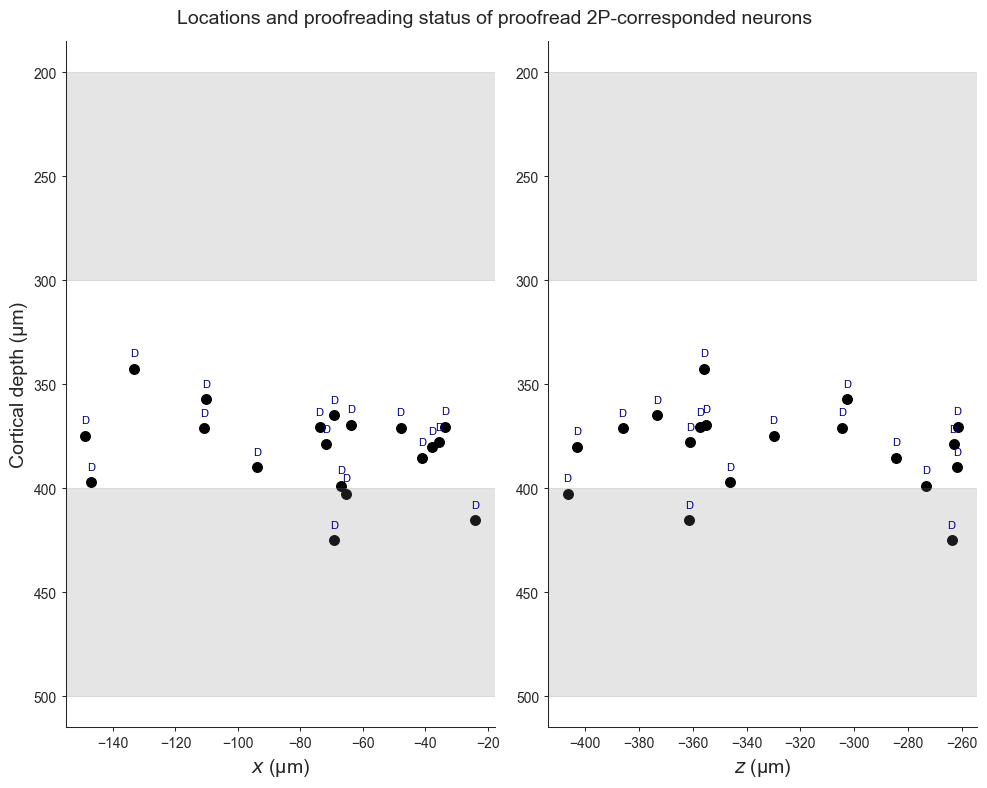

In [153]:
# Visualize the depths of these cells
x_positions = corresponded_proof.position_microns.apply(lambda pos: pos[0])
y_positions = corresponded_proof.position_microns.apply(lambda pos: pos[1])
z_positions = corresponded_proof.position_microns.apply(lambda pos: pos[2])
dendrite_proof = corresponded_proof.dendrite_proofreading_status.isin(V1DDEMClient.PROOFREADING_STATUS_COMPLETE)
axon_proof = corresponded_proof.axon_proofreading_status.isin(V1DDEMClient.PROOFREADING_STATUS_COMPLETE)

fig, axs = plt.subplots(figsize=(10, 8), ncols=2)

fig.suptitle("Locations and proofreading status of proofread 2P-corresponded neurons", fontsize=14)

ax = axs[0]
ax.scatter(x_positions, y_positions, color="black", s=50)
ax.set_xlabel("$x$ (µm)", fontsize=14)
ax.set_ylabel("Cortical depth (µm)", fontsize=14)

ax = axs[1]
ax.scatter(z_positions, y_positions, color="black", s=50)
ax.set_xlabel("$z$ (µm)", fontsize=14)

ylim = ax.get_ylim()

for ax, xpos in zip(axs, (x_positions, z_positions)):
    ax.invert_yaxis() # Open down

    # Text based on proofreading
    for x, y, dprf, aprf in zip(xpos, y_positions, dendrite_proof, axon_proof):
        if dprf or aprf:
            proof_text = "D" if dprf else ""
            if aprf: proof_text += "A"
            ax.text(x, y-6, proof_text, horizontalalignment="center", fontsize=8, color="darkblue")
        
        # ax.text(x, y-6, f"{y:.0f} µm", horizontalalignment="center", fontsize=10)

    # Shade depth chunks
    # 200-300, 300-400, 400-500, 500-600
    #    G        W        G        W
    ax.axhspan(ymin=200, ymax=300, color="gray", alpha=0.2)
    ax.axhspan(ymin=400, ymax=500, color="gray", alpha=0.2)
    # ax.set_ylim(ylim)

fig.tight_layout()

In [20]:
# Load the synapses of these cells
corresponded_pt_root_ids = corresponded_proof.pt_root_id.values
print(f"Loading dendritic synapses for {len(corresponded_pt_root_ids)} neurons...")
dendritic_synapses = em_client.get_dendritic_synapses(corresponded_pt_root_ids)
print(f"Done. Loading axonal synapses for {len(corresponded_pt_root_ids)} neurons...")
axonal_synapses = em_client.get_axonal_synapses(corresponded_pt_root_ids)
print(f"Done. There are {len(dendritic_synapses):,} total dendritic synapses and {len(axonal_synapses):,} total axonal synapses.")

Loading dendritic synapses for 19 neurons...
Done. Loading axonal synapses for 19 neurons...
Done. There are 51,260 total dendritic synapses and 8,389 total axonal synapses.


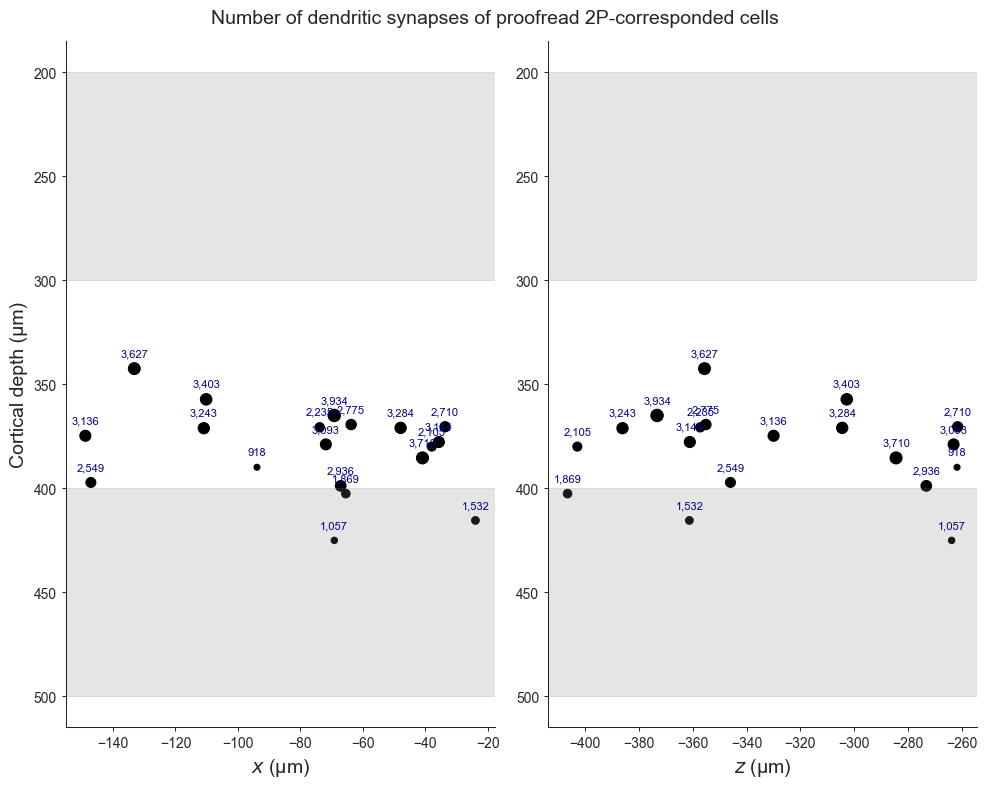

In [152]:
# Visualize the number of dendrites of these cells
x_positions = corresponded_proof.position_microns.apply(lambda pos: pos[0])
y_positions = corresponded_proof.position_microns.apply(lambda pos: pos[1])
z_positions = corresponded_proof.position_microns.apply(lambda pos: pos[2])
dendrite_proof = corresponded_proof.dendrite_proofreading_status.isin(V1DDEMClient.PROOFREADING_STATUS_COMPLETE)
axon_proof = corresponded_proof.axon_proofreading_status.isin(V1DDEMClient.PROOFREADING_STATUS_COMPLETE)
n_dendritic_synapses = dendritic_synapses.post_pt_root_id.value_counts()[corresponded_proof.pt_root_id]
scatter_size = 0.02 * n_dendritic_synapses.values

fig, axs = plt.subplots(figsize=(10, 8), ncols=2)

fig.suptitle("Number of dendritic synapses of proofread 2P-corresponded cells", fontsize=14)

ax = axs[0]
ax.scatter(x_positions, y_positions, color="black", s=scatter_size)
ax.set_xlabel("$x$ (µm)", fontsize=14)
ax.set_ylabel("Cortical depth (µm)", fontsize=14)

ax = axs[1]
ax.scatter(z_positions, y_positions, color="black", s=scatter_size)
ax.set_xlabel("$z$ (µm)", fontsize=14)

for ax, xpos in zip(axs, (x_positions, z_positions)):
    ax.invert_yaxis() # Open down

    # Text based on proofreading
    for x, y, n_d_syn in zip(xpos, y_positions, n_dendritic_synapses):
        ax.text(x, y-6, f"{n_d_syn:,}", horizontalalignment="center", fontsize=8, color="darkblue")

    # Shade depth chunks
    # 200-300, 300-400, 400-500, 500-600
    #    G        W        G        W
    ax.axhspan(ymin=200, ymax=300, color="gray", alpha=0.2)
    ax.axhspan(ymin=400, ymax=500, color="gray", alpha=0.2)
    # ax.set_ylim(ylim)

fig.tight_layout()

In [143]:
def anyna(*args):
    for arg in args:
        if np.any(pd.isna(arg)):
            return True
    return False

dist_fn_euc = lambda this, other: np.inf if anyna(this, other) else np.sqrt(np.sum(np.square(this - other)))
dist_fn_horiz = lambda this, other: np.inf if anyna(this, other) else np.sqrt(np.sum(np.square(this[[0, 2]] - other[[0, 2]])))
dist_fn_vert = lambda this, other: np.inf if anyna(this, other) else other[1] - this[1] # e.g., +200 means other is 200 microns deeper than this

def plot_dist(ax, syn, this_soma_position_key, other_position_key, dist_fn, syn_size_weighted=False):
    syn = syn.dropna(subset=other_position_key)
    dists = syn.apply(lambda row: dist_fn(row[this_soma_position_key], row[other_position_key]), axis=1)
    xmin, xmax = 0, (300 if other_position_key == "position_microns" else 700) # 300 microns for synapse distances
    dist_range = np.arange(xmin, xmax+1, 1) # Steps of 1 micron
    weights = syn["size"] if syn_size_weighted else None
    frac_within_dist = np.array([np.average(dists <= d, weights=weights) for d in dist_range])

    ax.plot(dist_range, frac_within_dist, linewidth=2)
    ax.set_xlabel("Distance ($\mu$m)", fontsize=14)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(0, 1)


def plot_vert_dist(ax, syn, this_soma_position_key, other_position_key, syn_size_weighted=False):
    syn = syn.dropna(subset=other_position_key)
    vert_pos = syn.apply(lambda row: row[other_position_key][1], axis=1)
    this_soma_vert_pos = syn[this_soma_position_key].values[0][1] # since all values are the same
    xmin, xmax = 0, 800, # np.max(other_soma_vert_pos)
    dist_range = np.arange(xmin, xmax+1, 1) # Steps of 1 micron
    weights = syn["size"] if syn_size_weighted else None
    frac_cells_within_dist = np.array([np.average(vert_pos <= d, weights=weights) for d in dist_range])

    p = ax.plot(dist_range, frac_cells_within_dist, linewidth=2)
    ax.scatter(this_soma_vert_pos, np.average(vert_pos <= this_soma_vert_pos, weights=weights), color=p[0].get_color(), s=50) # Draw point to show soma location
    ax.set_xlabel("Depth ($\mu$m)", fontsize=14)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(0, 1)

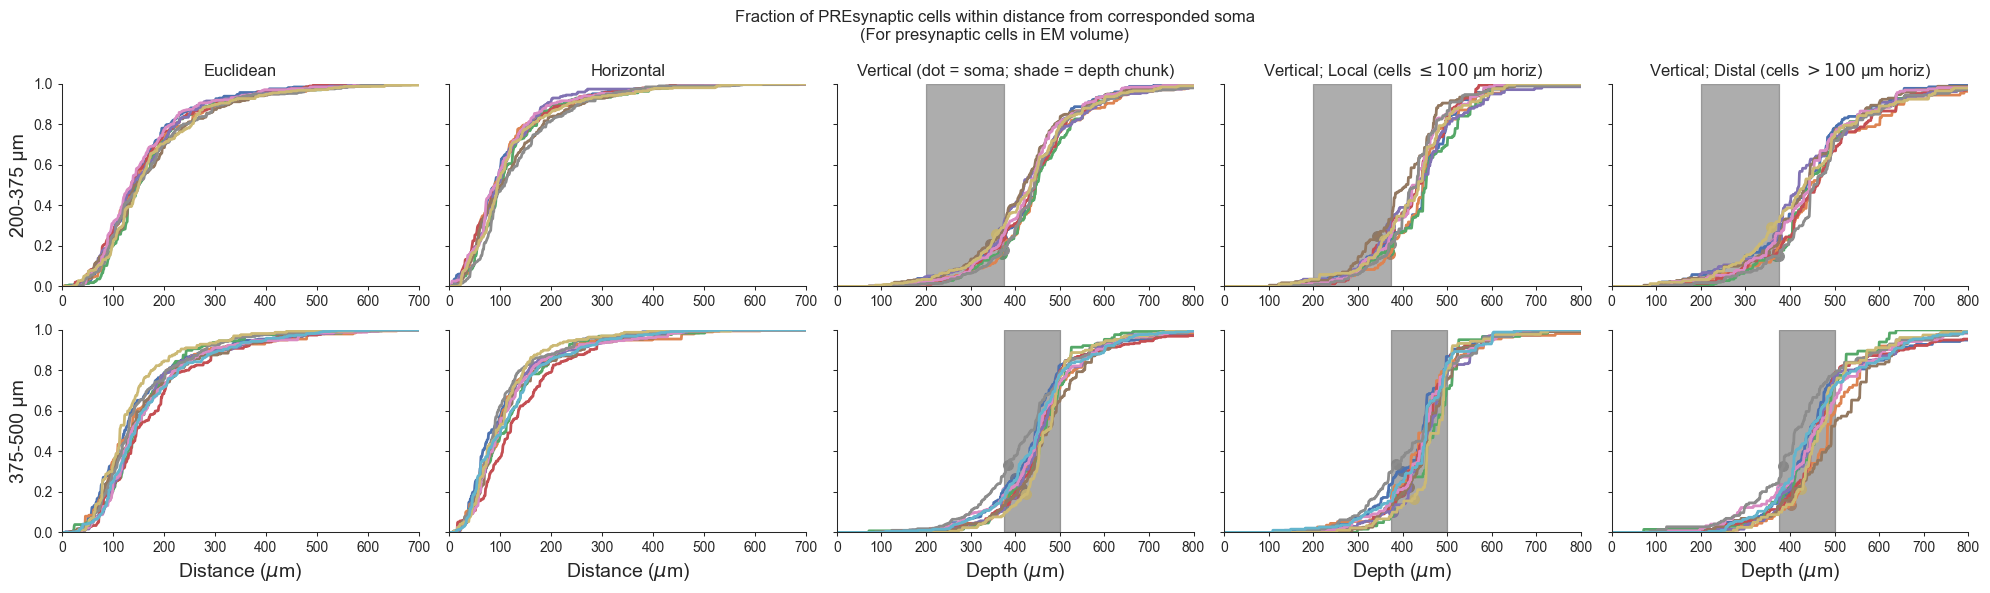

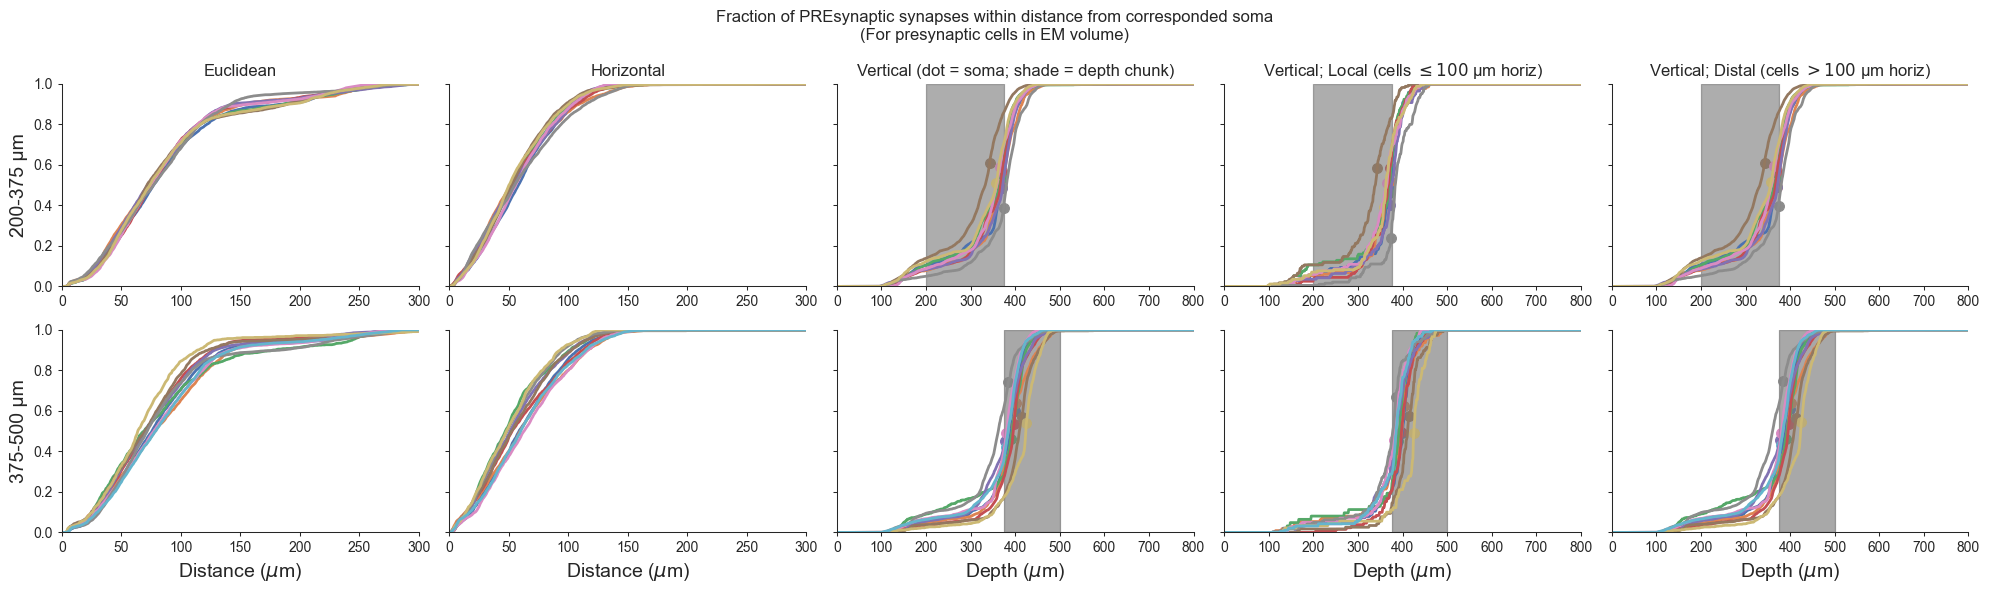

In [146]:
depth_chunks = [200, 375, 500]
# fig, axs = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
nrows, ncols = len(depth_chunks)-1, 5

for title_type, this_soma_position_key, other_position_key in (("cells", "post_soma_position", "pre_soma_position"), ("synapses", "post_soma_position", "position_microns")):
    # for syn_size_weighted in (False, True):
    for syn_size_weighted in (False,):
        fig, axs = plt.subplots(figsize=(20, 6), nrows=nrows, ncols=ncols)
        mc_cell_depths = corresponded_proof.position_microns.apply(lambda pos: pos[1])

        for col in range(ncols):
            for row, ax in enumerate(axs[:, col]):
                depth_min, depth_max = depth_chunks[row], depth_chunks[row+1]
                pt_root_ids_in_chunk = corresponded_proof.pt_root_id[(depth_min <= mc_cell_depths) & (mc_cell_depths < depth_max)]

                for pt_root_id in pt_root_ids_in_chunk:
                    cell_den_syn = dendritic_synapses[dendritic_synapses.post_pt_root_id == pt_root_id]
                    cell_den_syn_has_ophys = cell_den_syn[cell_den_syn.pre_pt_root_id.isin(corresponded.pt_root_id)]
                    presyn_rois = cell_den_syn_has_ophys.pre_pt_root_id.apply(lambda pt_root_id: corresponding_roi[pt_root_id])
                    # presyn_metrics = metrics.loc[roi_lookup_to_metrics_idx[presyn_rois].values]
                    
                    cell_axo_syn = axonal_synapses[axonal_synapses.pre_pt_root_id == pt_root_id]
                    cell_axo_syn_has_ophys = cell_axo_syn[cell_axo_syn.post_pt_root_id.isin(corresponded.pt_root_id)]
                    postsyn_rois = cell_axo_syn_has_ophys.post_pt_root_id.apply(lambda pt_root_id: corresponding_roi[pt_root_id])
                    # postsyn_metrics = metrics.loc[roi_lookup_to_metrics_idx[postsyn_rois].values]

                    if col == 0:
                        plot_dist(ax, cell_den_syn, this_soma_position_key, other_position_key, dist_fn_euc, syn_size_weighted=syn_size_weighted)
                        if row == 0: ax.set_title("Euclidean")
                    if col == 1:
                        plot_dist(ax, cell_den_syn, this_soma_position_key, other_position_key, dist_fn_horiz, syn_size_weighted=syn_size_weighted)
                        if row == 0: ax.set_title("Horizontal")
                    elif col == 2:
                        plot_vert_dist(ax, cell_den_syn, this_soma_position_key, other_position_key, syn_size_weighted=syn_size_weighted)
                        if row == 0: ax.set_title("Vertical (dot = soma; shade = depth chunk)")
                        ax.axvspan(depth_min, depth_max, color="gray", alpha=0.1)
                    elif col == 3:
                        cell_den_syn_local = cell_den_syn[cell_den_syn.apply(lambda row: dist_fn_horiz(row["post_soma_position"], row["pre_soma_position"]), axis=1) <= 100]
                        plot_vert_dist(ax, cell_den_syn_local, this_soma_position_key, other_position_key, syn_size_weighted=syn_size_weighted)
                        if row == 0: ax.set_title("Vertical; Local (cells $\leq 100$ µm horiz)")
                        ax.axvspan(depth_min, depth_max, color="gray", alpha=0.1)
                    elif col == 4:
                        cell_den_syn_local = cell_den_syn[cell_den_syn.apply(lambda row: dist_fn_horiz(row["post_soma_position"], row["pre_soma_position"]), axis=1) > 100]
                        plot_vert_dist(ax, cell_den_syn_local, this_soma_position_key, other_position_key, syn_size_weighted=syn_size_weighted)
                        if row == 0: ax.set_title("Vertical; Distal (cells $>100$ µm horiz)")
                        ax.axvspan(depth_min, depth_max, color="gray", alpha=0.1)
                    
                if row < nrows-1: ax.set_xlabel("")

                if col == 0:
                    # ax.set_ylabel(f"{depth_min}-{depth_max} µm ({len(pt_root_ids_in_chunk)} MCs)", fontsize=14)
                    ax.set_ylabel(f"{depth_min}-{depth_max} µm", fontsize=14)
                    # ax.legend(ax.lines, [f"$\cdots${str(pt_root_id)[-3:]}" for pt_root_id in pt_root_ids_in_chunk], loc="center right")
                else:
                    ax.set_yticklabels([])

        fig.suptitle(f"Fraction of PREsynaptic {title_type} within distance from corresponded soma{', weighted by synapse size' if syn_size_weighted else ''}\n(For presynaptic cells in EM volume)")
        fig.tight_layout()

In [173]:
cell_type_table = em_client.get_cell_type_table()
cell_type_map = pd.Series(data=cell_type_table.cell_type.values, index=cell_type_table.pt_root_id.values)
cell_type_table.head()

,index,id,valid,target_id,classification_system,cell_type,id_ref,valid__ref,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position,position_microns,axon_proofreading_status,dendrite_proofreading_status
0,0,1132,t,350562,coarse_manual,PYC,350562,t,326.965400,94866276031228266,864691132773514104,"[894573, 478559, 163530]","[891003, 473981, 17111]","[898608, 483370, 18134]","[-13.227572489957907, 226.5862979342913, -382....",not_started,not_started
1,1,214,t,383955,coarse_manual,PYC,383955,t,504.192300,95649060060623076,864691132569667100,"[920802, 795478, 329220]","[914826, 790822, 34920]","[926389, 800366, 36123]","[14.741818935006158, 576.1578669978572, -307.2...",not_started,not_started
2,2,13,t,385028,coarse_manual,PYC,385028,t,415.785065,95863052645657911,864691132781402571,"[929338, 898530, 386595]","[924914, 892245, 41162]","[933994, 903885, 42103]","[23.848399659480666, 690.7637364002102, -279.5...",not_started,not_started
3,3,717,t,293764,coarse_manual,PYC,293764,t,231.369357,94450111081742956,864691132625300120,"[878665, 697702, 245475]","[874009, 694365, 26030]","[883554, 701349, 26859]","[-27.97517873296875, 459.74380331495826, -361....",not_started,not_started
4,4,2604,t,351373,coarse_manual,PYC,351373,t,277.321739,96276193669654108,864691132689074198,"[944314, 572378, 210330]","[939814, 568187, 22179]","[948505, 576413, 23110]","[37.02512562261708, 329.260361441734, -362.108...",not_started,not_started


In [178]:
print("Format: {2P corresponded} / {soma in EM volume} / {total}")

def count_cells_of_type(pt_root_ids, cell_type):
    if type(cell_type) is str:
        cell_type = [cell_type]

    pt_root_ids = pt_root_ids[pt_root_ids.isin(cell_type_map.index)]
    return cell_type_map[pt_root_ids].isin(["MC"]).sum()

for i in range(len(depth_chunks) - 1):
    depth_min, depth_max = depth_chunks[i], depth_chunks[i+1]
    in_chunk = (depth_min <= mc_cell_depths) & (mc_cell_depths < depth_max)
    pt_root_ids_in_chunk = corresponded_proof.pt_root_id[in_chunk]
    dproof, aproof = corresponded_proof.dendrite_proofreading_status[in_chunk].isin(V1DDEMClient.PROOFREADING_STATUS_COMPLETE), corresponded_proof.axon_proofreading_status[in_chunk].isin(V1DDEMClient.PROOFREADING_STATUS_COMPLETE)

    print(f"\n====== {depth_min} to {depth_max} µm ======")
    
    for pt_root_id, depth, dp, ap in zip(pt_root_ids_in_chunk, mc_cell_depths[in_chunk], dproof, aproof):
        print(f"\n - {pt_root_id} ({'D' if dp else ''}{'A' if ap else ''}) ({depth:.0f} µm)")

        den_syn = dendritic_synapses[dendritic_synapses.post_pt_root_id == pt_root_id]
        axo_syn = axonal_synapses[axonal_synapses.pre_pt_root_id == pt_root_id]
        den_syn_unique = den_syn.drop_duplicates("pre_pt_root_id")
        axo_syn_unique = axo_syn.drop_duplicates("post_pt_root_id")
        n_in_vol_pre = np.count_nonzero(~den_syn.pre_soma_position.isna())
        n_in_vol_post = np.count_nonzero(~axo_syn.post_soma_position.isna())
        n_in_vol_pre_unique = np.count_nonzero(~den_syn_unique.pre_soma_position.isna())
        n_in_vol_post_unique = np.count_nonzero(~axo_syn_unique.post_soma_position.isna())
        n_corresponded_pre = den_syn.pre_pt_root_id.isin(corresponded.pt_root_id).sum()
        n_corresponded_post = axo_syn.post_pt_root_id.isin(corresponded.pt_root_id).sum()
        n_corresponded_pre_unique = den_syn_unique.pre_pt_root_id.isin(corresponded.pt_root_id).sum()
        n_corresponded_post_unique = axo_syn.post_pt_root_id.isin(corresponded.pt_root_id).sum()
        n_mc_pre = count_cells_of_type(den_syn.pre_pt_root_id, "MC")
        n_mc_post = count_cells_of_type(axo_syn.post_pt_root_id, "MC")

        print(f"    DEN: {n_corresponded_pre} / {n_in_vol_pre} / {len(den_syn)}   (Unique: {n_corresponded_pre_unique} / {n_in_vol_pre_unique} / {len(den_syn_unique)}) (Is MC: {n_mc_pre} / {n_in_vol_pre})")
        print(f"    AXO: {n_corresponded_post} / {n_in_vol_post} / {len(axo_syn)}   (Unique: {n_corresponded_post_unique} / {n_in_vol_post_unique} / {len(axo_syn_unique)}) (Is MC: {n_mc_post} / {n_in_vol_post})")

Format: {2P corresponded} / {soma in EM volume} / {total}

====== 200 to 375 µm ======

 - 864691132771651091 (D) (371 µm)
    DEN: 1 / 329 / 3284   (Unique: 1 / 195 / 3055) (Is MC: 83 / 329)
    AXO: 0 / 14 / 25   (Unique: 0 / 14 / 25) (Is MC: 0 / 14)

 - 864691132771649811 (D) (371 µm)
    DEN: 1 / 241 / 2235   (Unique: 1 / 155 / 2101) (Is MC: 53 / 241)
    AXO: 0 / 8 / 17   (Unique: 0 / 8 / 17) (Is MC: 1 / 8)

 - 864691132630689122 (D) (369 µm)
    DEN: 0 / 272 / 2775   (Unique: 0 / 166 / 2595) (Is MC: 69 / 272)
    AXO: 2 / 476 / 778   (Unique: 2 / 384 / 682) (Is MC: 23 / 476)

 - 864691132835126165 (D) (370 µm)
    DEN: 0 / 284 / 2710   (Unique: 0 / 184 / 2531) (Is MC: 63 / 284)
    AXO: 0 / 340 / 512   (Unique: 0 / 283 / 454) (Is MC: 25 / 340)

 - 864691132598347327 (D) (371 µm)
    DEN: 2 / 273 / 3243   (Unique: 2 / 189 / 3062) (Is MC: 41 / 273)
    AXO: 0 / 126 / 206   (Unique: 0 / 106 / 186) (Is MC: 17 / 126)

 - 864691132621003707 (D) (342 µm)
    DEN: 0 / 340 / 3627   (Uniqu

## Load ophys metrics

In [179]:
# Load metrics since we'll need that too
from stimulus_analysis import fit_utils

metrics = pd.read_csv("/Users/chase/Desktop/MindScope/Documents/v1dd-chase/dataframes/v1dd_metrics.csv", index_col=0, low_memory=False)

# Only consider valid metrics
metrics = metrics[metrics.is_valid & (metrics.mouse == 409828) & (metrics.column == 1)]
metrics.insert(5, "roi_lookup", metrics.apply(lambda row: f"{row.column}-{row.volume}-{row.plane}-{row.roi}", axis=1))
metrics["ssi_fit"] = fit_utils.compute_dg_fit_ssi_from_metrics(metrics)
metrics["dgw_pref_dir_fit"] = fit_utils.get_dg_pref_dir(metrics, "dgw")
metrics["dgf_pref_dir_fit"] = fit_utils.get_dg_pref_dir(metrics, "dgf")

roi_lookup_to_metrics_idx = pd.Series(data=metrics.index, index=metrics.roi_lookup.values)

metrics.head()

,mouse,column,volume,plane,roi,roi_lookup,is_valid,depth,dgf_pref_response,dgf_pref_dir,...,ssi,ffsi,ssi_pref_both,ssi_orth,ffsi_all_dirs,spontaneous_event_mean,spontaneous_event_std,ssi_fit,dgw_pref_dir_fit,dgf_pref_dir_fit
M409828_11_1_89,409828,1,1,1,89,1-1-1-89,True,50,0.000943,330.0,...,0.265065,0.419054,0.033453,-0.139243,"[0.41905364, 0.61911654, 0.07141414, -0.801465...",0.000287,0.001903,0.173092,351.613700,63.683119
M409828_11_2_0,409828,1,1,2,0,1-1-2-0,True,66,0.000919,270.0,...,-0.084075,-0.183585,-0.088211,0.064530,"[-0.18358487, 0.04251838, -0.30215508, -0.1352...",0.000346,0.002629,-0.076999,46.319837,71.813432
M409828_11_2_1,409828,1,1,2,1,1-1-2-1,True,66,0.011217,0.0,...,-0.065169,-0.139425,-0.157938,0.044509,"[-4.483465, -0.13942526, -0.10395071, 1.0, -1....",0.000341,0.002262,-0.357757,20.629574,14.344481
M409828_11_2_2,409828,1,1,2,2,1-1-2-2,True,66,0.001237,120.0,...,0.536319,0.698187,-0.005231,-0.203358,"[-0.3096417, 0.6981869, 0.36546794, 0.25718334...",0.000341,0.002412,0.238414,360.000000,63.556494
M409828_11_2_4,409828,1,1,2,4,1-1-2-4,True,66,0.001093,240.0,...,-0.034136,-0.070685,-0.278688,-0.394162,"[-1.098053, -0.15058127, -0.28383604, -2.51381...",0.000234,0.001601,-0.131294,349.940152,323.599541


## For these proofread cells, plot the number of MC presynaptic synapses vs. SSI

Text(0, 0.5, 'Fraction of presynaptic MC cells')

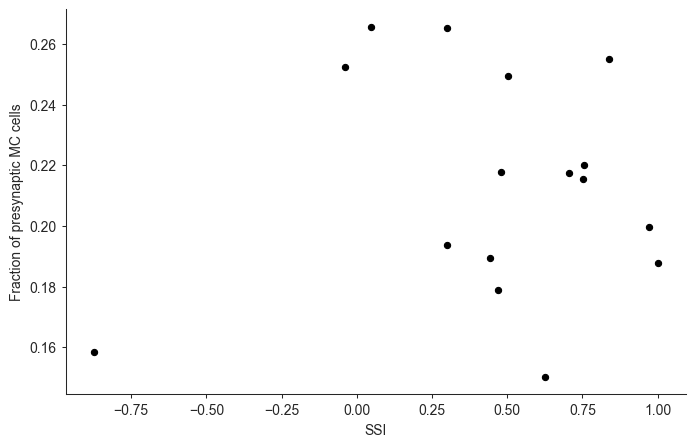

In [184]:
fig, ax = plt.subplots(figsize=(8, 5))

ssi = []
frac_mc = []

for i, row in corresponded_proof.iterrows():
    pt_root_id = row.pt_root_id

    den_syn = dendritic_synapses[dendritic_synapses.post_pt_root_id == pt_root_id]
    den_syn_unique = den_syn.drop_duplicates("pre_pt_root_id")
    n_in_vol_pre = np.count_nonzero(~den_syn.pre_soma_position.isna())
    n_in_vol_pre_unique = np.count_nonzero(~den_syn_unique.pre_soma_position.isna())
    n_in_vol_post_unique = np.count_nonzero(~axo_syn_unique.post_soma_position.isna())
    n_corresponded_pre = den_syn.pre_pt_root_id.isin(corresponded.pt_root_id).sum()
    n_corresponded_post = axo_syn.post_pt_root_id.isin(corresponded.pt_root_id).sum()
    n_corresponded_pre_unique = den_syn_unique.pre_pt_root_id.isin(corresponded.pt_root_id).sum()
    n_corresponded_post_unique = axo_syn.post_pt_root_id.isin(corresponded.pt_root_id).sum()
    n_mc_pre = count_cells_of_type(den_syn.pre_pt_root_id, "MC")

    metrics_index = roi_lookup_to_metrics_idx[row.roi_lookup]
    ssi.append(metrics.at[metrics_index, "ssi_fit"])
    frac_mc.append(n_mc_pre / n_in_vol_pre)

ax.scatter(ssi, frac_mc, color="black", s=20)
ax.set_xlabel("SSI")
ax.set_ylabel("Fraction of presynaptic MC cells")

## For a single Martinotti cell, examine visual response properties of (a) presynaptic and (b) postsynaptic neurons

In [13]:
# This is an example MC that has a lot of synapses from/on 2P-corresponded cells
mc_pt_root_id = 864691132782970098

,mouse,column,volume,plane,roi,roi_lookup,is_valid,depth,dgf_pref_response,dgf_pref_dir,...,ssi,ffsi,ssi_pref_both,ssi_orth,ffsi_all_dirs,spontaneous_event_mean,spontaneous_event_std,ssi_fit,dgw_pref_dir_fit,dgf_pref_dir_fit
M409828_11_1_89,409828,1,1,1,89,1-1-1-89,True,50,0.000943,330.0,...,0.265065,0.419054,0.033453,-0.139243,"[0.41905364, 0.61911654, 0.07141414, -0.801465...",0.000287,0.001903,0.173092,351.613700,63.683119
M409828_11_2_0,409828,1,1,2,0,1-1-2-0,True,66,0.000919,270.0,...,-0.084075,-0.183585,-0.088211,0.064530,"[-0.18358487, 0.04251838, -0.30215508, -0.1352...",0.000346,0.002629,-0.076999,46.319837,71.813432
M409828_11_2_1,409828,1,1,2,1,1-1-2-1,True,66,0.011217,0.0,...,-0.065169,-0.139425,-0.157938,0.044509,"[-4.483465, -0.13942526, -0.10395071, 1.0, -1....",0.000341,0.002262,-0.357757,20.629574,14.344481
M409828_11_2_2,409828,1,1,2,2,1-1-2-2,True,66,0.001237,120.0,...,0.536319,0.698187,-0.005231,-0.203358,"[-0.3096417, 0.6981869, 0.36546794, 0.25718334...",0.000341,0.002412,0.238414,360.000000,63.556494
M409828_11_2_4,409828,1,1,2,4,1-1-2-4,True,66,0.001093,240.0,...,-0.034136,-0.070685,-0.278688,-0.394162,"[-1.098053, -0.15058127, -0.28383604, -2.51381...",0.000234,0.001601,-0.131294,349.940152,323.599541


(a) First examine presynaptic cells

In [133]:
cell_den_syn = dendritic_synapses[dendritic_synapses.post_pt_root_id == mc_pt_root_id]
print(f"{len(cell_den_syn):,} rows")
cell_den_syn.head()

10,474 rows


,index,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position,position_microns,pre_soma_position,post_soma_position
10,10,457645374,t,95363255756905645,864691132739753369,95292887012697142,864691132782970098,1044,"[93898, 65814, 7349]","[93881, 65805, 7342]","[93878, 65808, 7344]","[3.8334197367437883, 425.0897811919907, -264.0...","[24.888653725584504, 494.5348293198027, -277.6...","[-4.422008686702349, 421.1469265512653, -300.8..."
36,36,457646123,t,95433693220444742,864691132786044348,95363324476261272,864691132782970098,2587,"[94158, 66066, 7262]","[94109, 66038, 7255]","[94129, 66066, 7254]","[6.050615197377512, 426.2083798736269, -268.45...",None,"[-4.422008686702349, 421.1469265512653, -300.8..."
38,38,519016667,t,97473562101271570,864691132278939908,97473562101274902,864691132782970098,492,"[101742, 62938, 7176]","[101741, 62918, 7184]","[101756, 62928, 7181]","[79.9306949023126, 395.8254554407017, -263.432...",None,"[-4.422008686702349, 421.1469265512653, -300.8..."
60,60,446863400,t,94872873436750427,864691132957090513,94872873436759889,864691132782970098,1210,"[92157, 74101, 6393]","[92181, 74099, 6404]","[92181, 74101, 6403]","[-12.326772604929749, 491.3877048078616, -326....",None,"[-4.422008686702349, 421.1469265512653, -300.8..."
63,63,480384827,t,95782581802604242,864691132854190880,95782581802596628,864691132782970098,770,"[95426, 55049, 5825]","[95485, 55061, 5819]","[95465, 55087, 5820]","[18.8008839239449, 306.2543393140738, -302.214...",None,"[-4.422008686702349, 421.1469265512653, -300.8..."


In [134]:
cell_den_syn_has_ophys = cell_den_syn[cell_den_syn.pre_pt_root_id.isin(corresponded_table.pt_root_id)]
print(f"{len(cell_den_syn_has_ophys):,} rows")
cell_den_syn_has_ophys.head()

49 rows


,index,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position,position_microns,pre_soma_position,post_soma_position
4758,4779,408427345,t,93392106084731532,864691132754582962,93392106084740111,864691132782970098,591,"[86816, 62759, 5707]","[86809, 62761, 5710]","[86826, 62766, 5710]","[-65.0035963878932, 377.32360005293634, -326.9...","[-116.25441502719082, 372.3245112135671, -303....","[-4.422008686702349, 421.1469265512653, -300.8..."
6852,6888,446645746,t,95013817083629848,864691132719988723,95013817083626386,864691132782970098,984,"[92642, 74778, 6467]","[92628, 74828, 6465]","[92635, 74791, 6464]","[-7.95335481450148, 498.9140696460378, -325.53...","[-125.15125066634046, 346.6647280266727, -313....","[-4.422008686702349, 421.1469265512653, -300.8..."
9113,9155,460680471,t,95292680653264270,864691132801571037,95292680653261496,864691132782970098,1622,"[93831, 65144, 6058]","[93853, 65110, 6051]","[93849, 65108, 6051]","[3.4520818490629317, 403.0446066134006, -318.2...","[-9.415707832006506, 353.3162675363157, -319.5...","[-4.422008686702349, 421.1469265512653, -300.8..."
10293,10341,418143094,t,93955468355393600,864691132760197483,93955468355407496,864691132782970098,1452,"[88876, 64228, 6013]","[88911, 64216, 6022]","[88883, 64200, 6018]","[-44.52805303209275, 394.5786687706597, -317.1...","[-47.89515902186779, 371.0004188124802, -304.4...","[-4.422008686702349, 421.1469265512653, -300.8..."
12959,13025,434535202,t,94448324375221140,864691132635895079,94448324375218669,864691132782970098,115,"[90634, 65264, 5311]","[90620, 65254, 5311]","[90616, 65262, 5315]","[-27.945301399591845, 395.6326190892443, -350....","[-84.5002040614849, 375.5022308609855, -323.36...","[-4.422008686702349, 421.1469265512653, -300.8..."


In [194]:
# Get the 2P ROIs of the corresponded presynaptic cells and the corresponding metrics
presyn_rois = cell_den_syn_has_ophys.pre_pt_root_id.apply(lambda pt_root_id: corresponding_roi[pt_root_id])
metrics_idx = roi_lookup_to_metrics_idx[presyn_rois].values
presyn_metrics = metrics.loc[metrics_idx]

Analyze visual response properties of these ROIs

<AxesSubplot: >

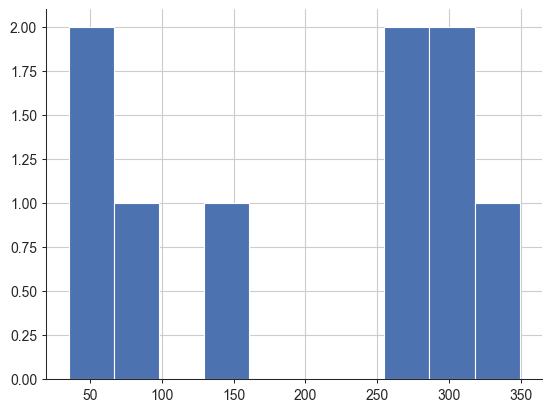

In [195]:
presyn_metrics[presyn_metrics.dgw_frac_responsive_trials >= 0.5].dgw_pref_dir_fit.hist()

<AxesSubplot: >

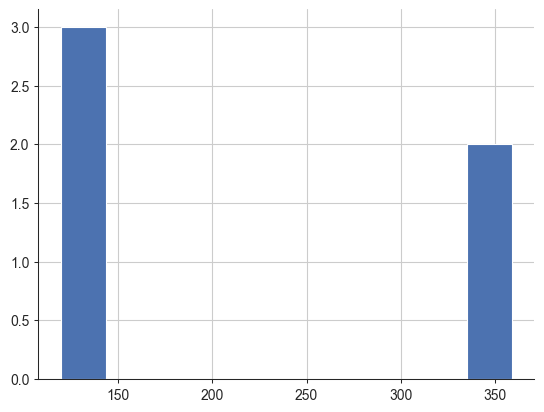

In [196]:
presyn_metrics[presyn_metrics.dgf_frac_responsive_trials >= 0.5].dgf_pref_dir_fit.hist()

<AxesSubplot: >

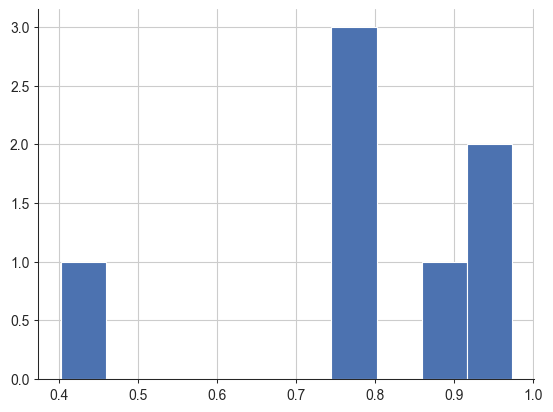

In [197]:
presyn_metrics[presyn_metrics.dgw_frac_responsive_trials >= 0.5].ssi_fit.hist()

(b) Do the same for postsynaptic cells

In [188]:
cell_axo_syn = axonal_synapses[axonal_synapses.pre_pt_root_id == mc_pt_root_id]
print(f"{len(cell_axo_syn):,} rows")

cell_axo_syn_has_ophys = cell_axo_syn[cell_axo_syn.post_pt_root_id.isin(corresponded_table.pt_root_id)]
print(f"{len(cell_axo_syn_has_ophys):,} rows have ophys")

postsyn_rois = cell_axo_syn_has_ophys.post_pt_root_id.apply(lambda pt_root_id: corresponding_roi[pt_root_id])
postsyn_metrics = metrics.loc[roi_lookup_to_metrics_idx[postsyn_rois].values]

8,903 rows
119 rows have ophys


<AxesSubplot: >

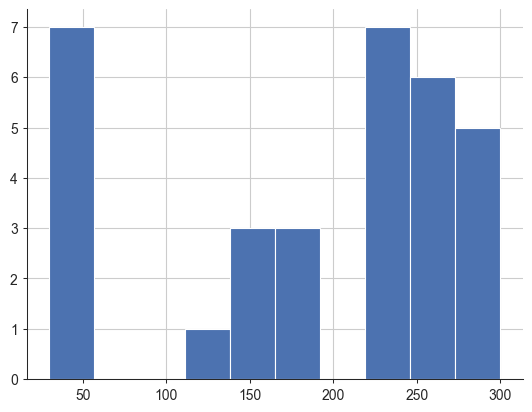

In [189]:
postsyn_metrics[postsyn_metrics.dgw_frac_responsive_trials >= 0.5].dgw_pref_dir.hist()

<AxesSubplot: >

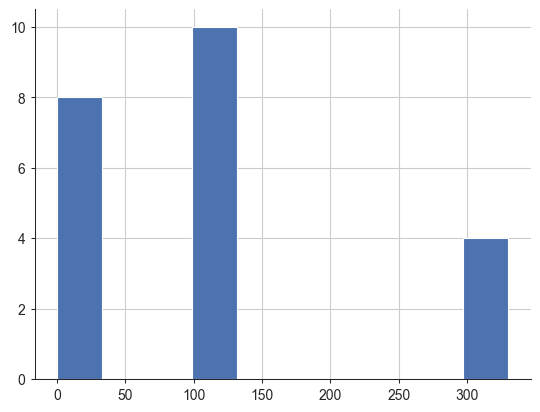

In [190]:
postsyn_metrics[postsyn_metrics.dgf_frac_responsive_trials >= 0.5].dgf_pref_dir.hist()

In [192]:
postsyn_metrics.roi_lookup.unique()

array(['1-3-5-109', '1-3-2-145', '1-3-3-158', '1-3-3-414', '1-3-4-212',
       '1-3-1-209', '1-3-1-671', '1-3-1-65', '1-3-3-14', '1-3-4-98',
       '1-3-3-250', '1-3-3-265', '1-3-3-74', '1-3-3-230', '1-3-3-139',
       '1-3-3-300', '1-3-1-88', '1-3-1-40', '1-3-1-60', '1-3-1-117',
       '1-3-4-89', '1-3-3-25', '1-3-6-470', '1-3-2-75', '1-3-3-269',
       '1-3-5-119', '1-3-5-419', '1-3-2-26', '1-3-4-387', '1-3-3-191',
       '1-3-1-67', '1-3-2-30', '1-3-3-237', '1-3-3-294', '1-3-3-215',
       '1-3-4-306', '1-3-2-667'], dtype=object)

## Visualize all MC cell distributions

In [30]:
dendritic_synapses

,index,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position,position_microns,pre_soma_position,post_soma_position
0,0,367566357,t,91349350718354439,864691132729026229,91349350718349683,864691132546844738,1103,"[79418, 55015, 4514]","[79478, 55066, 4511]","[79454, 55053, 4512]","[-136.543288309476, 291.3180259709305, -358.93...",None,"[-137.95332250863942, 347.0839533928604, -272...."
1,1,358220849,t,90858212551021515,864691132747416296,90858212551017131,864691132770775571,328,"[77676, 60411, 3983]","[77650, 60382, 3984]","[77644, 60405, 3984]","[-154.05896145033208, 334.7408968026274, -395....",None,"[-142.5850436612497, 383.1122453549287, -376.4..."
2,2,338348431,t,90574332593913202,864691132938820967,90574332593910751,864691132546844738,651,"[76720, 51463, 5523]","[76669, 51479, 5516]","[76699, 51489, 5516]","[-163.8968617497402, 270.0359815871785, -306.0...",None,"[-137.95332250863942, 347.0839533928604, -272...."
3,3,425306088,t,93599157801379970,864691132783522357,93599157801376256,864691132770775571,955,"[87547, 47625, 5490]","[87509, 47581, 5490]","[87514, 47609, 5489]","[-58.93306277229917, 232.76912387943378, -297....",None,"[-142.5850436612497, 383.1122453549287, -376.4..."
4,4,429148061,t,94163413156590377,864691132598544271,94163413156591353,864691132770775571,487,"[89771, 52455, 3579]","[89772, 52407, 3579]","[89773, 52406, 3579]","[-36.872308273772475, 254.74358913424135, -392...",None,"[-142.5850436612497, 383.1122453549287, -376.4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83317,83687,340365032,t,90504445221543275,864691132712055301,90504445221553961,864691133121058917,470,"[76223, 53372, 7986]","[76227, 53320, 7987]","[76246, 53349, 7986]","[-167.95040071477067, 317.02828761672464, -203...","[-74.45965800813084, 490.70150445470296, -249....","[-99.38341323076317, 378.7116193209634, -281.6..."
83318,83688,472757693,t,95924624826933797,864691131711936674,95924556107463744,864691132656476120,263,"[96029, 59784, 4886]","[96016, 59766, 4892]","[96023, 59778, 4889]","[24.114818669411704, 339.0346499170619, -354.6...",None,"[47.9745589016187, 346.39648610881903, -345.16..."
83319,83689,348216626,t,91138175900472780,864691132797123075,91138175900477525,864691132823412073,2400,"[78727, 54850, 5445]","[78750, 54854, 5440]","[78745, 54845, 5446]","[-143.55895996614115, 300.5623998087334, -318....",None,"[-169.1360545116018, 380.96626861854804, -289...."
83320,83690,477318819,t,96065774699221984,864691132092095000,96065774699212812,864691132656476120,601,"[96649, 61360, 5374]","[96693, 61347, 5373]","[96660, 61369, 5375]","[30.784028261697618, 359.571845196025, -337.87...",None,"[47.9745589016187, 346.39648610881903, -345.16..."


In [42]:
np.count_nonzero(~dendritic_synapses.pre_soma_position.isna())

6322

In [71]:
dendritic_synapses.head(1)

,index,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position,position_microns,pre_soma_position,post_soma_position
0,0,367566357,t,91349350718354439,864691132729026229,91349350718349683,864691132546844738,1103,"[79418, 55015, 4514]","[79478, 55066, 4511]","[79454, 55053, 4512]","[-136.543288309476, 291.3180259709305, -358.93...",None,"[-137.95332250863942, 347.0839533928604, -272...."


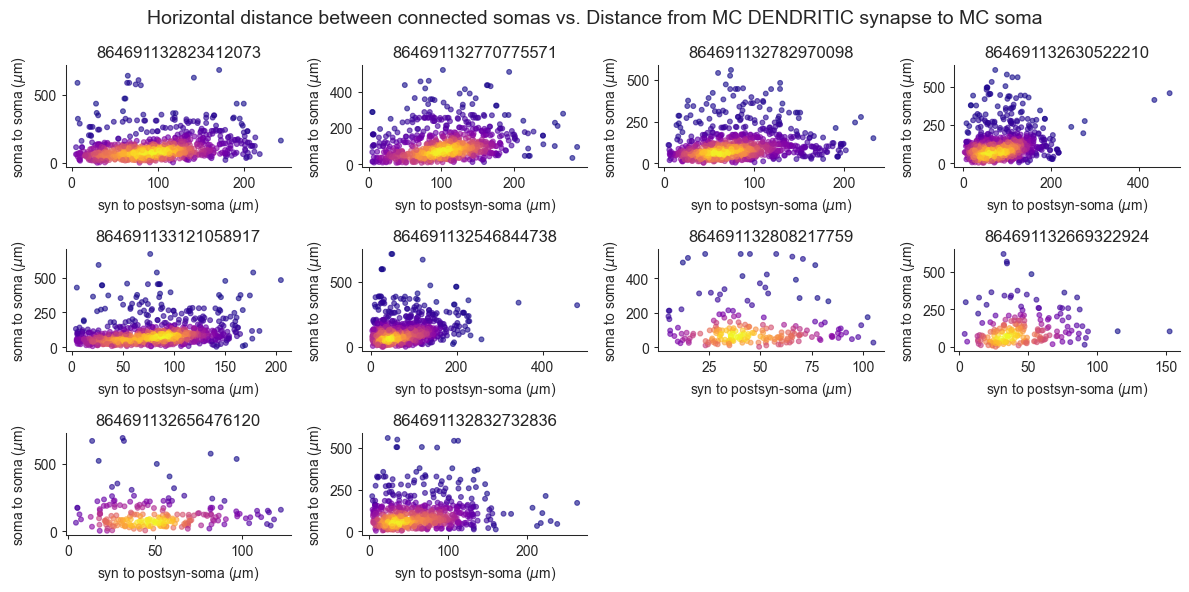

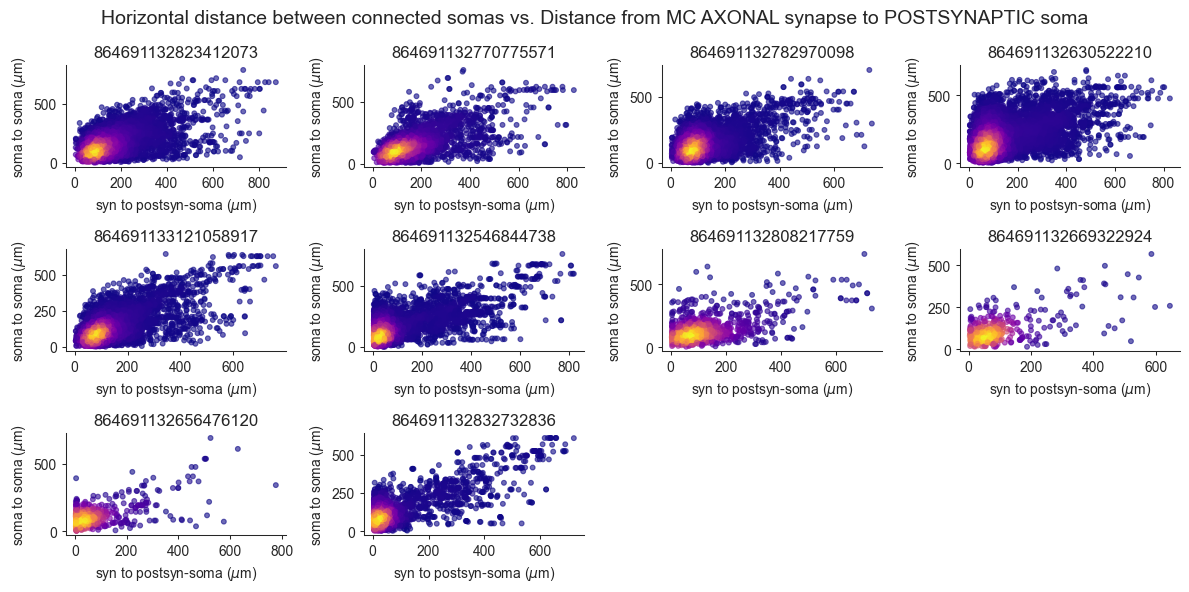

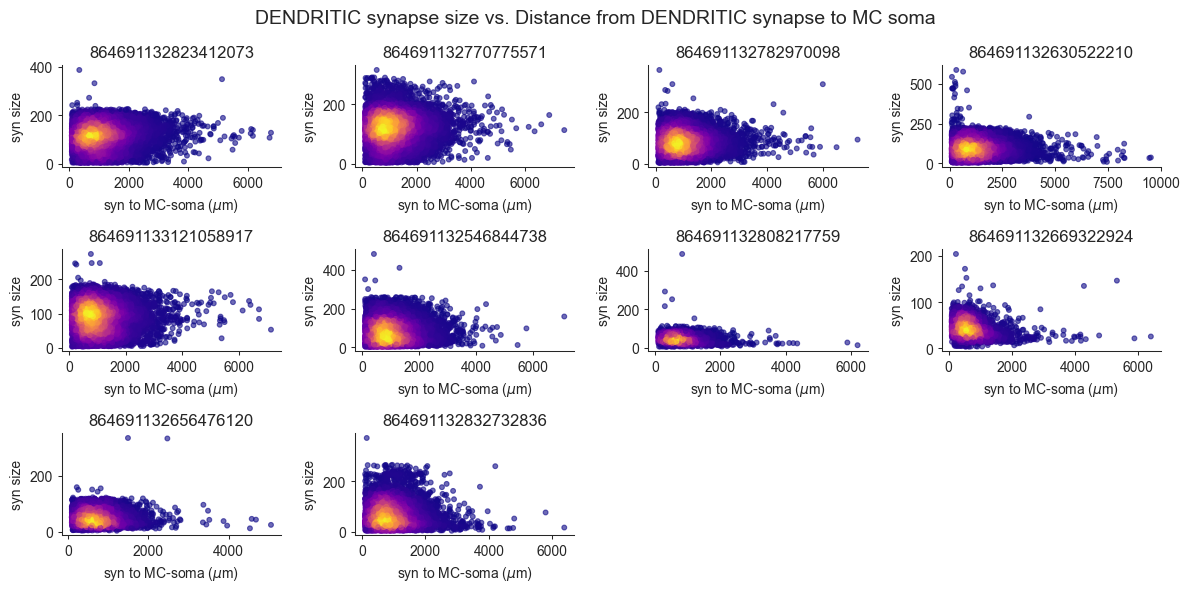

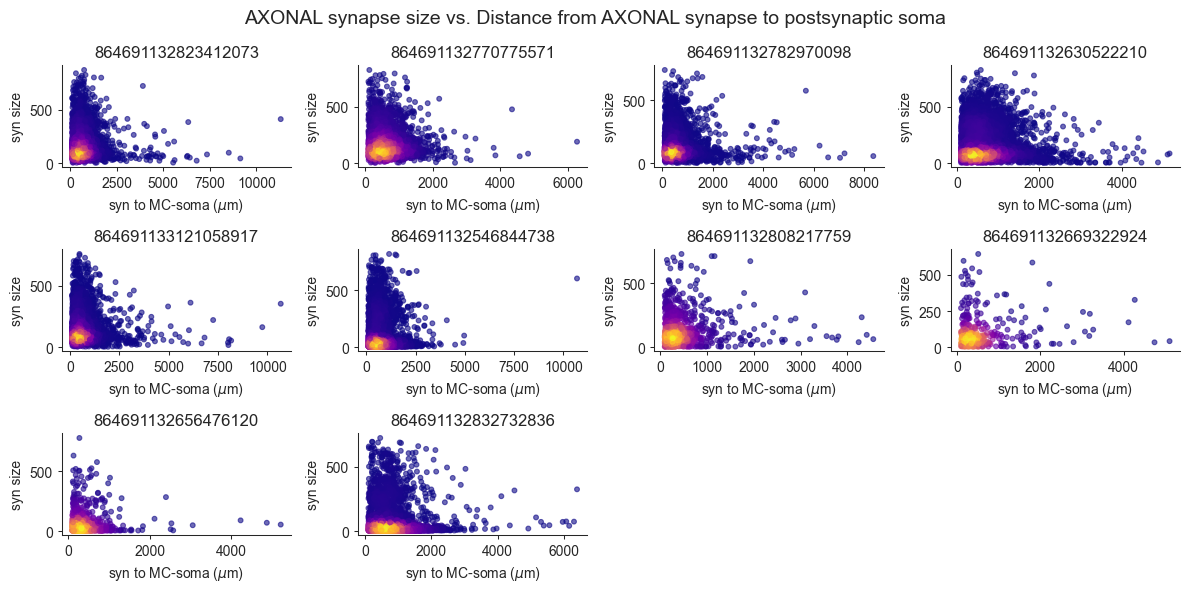

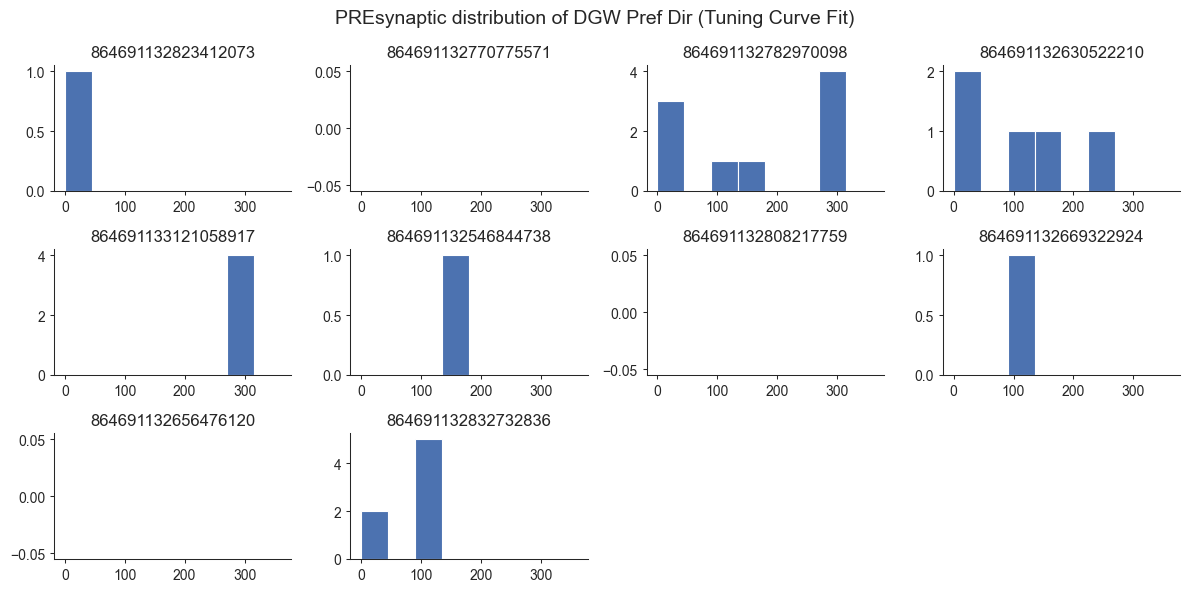

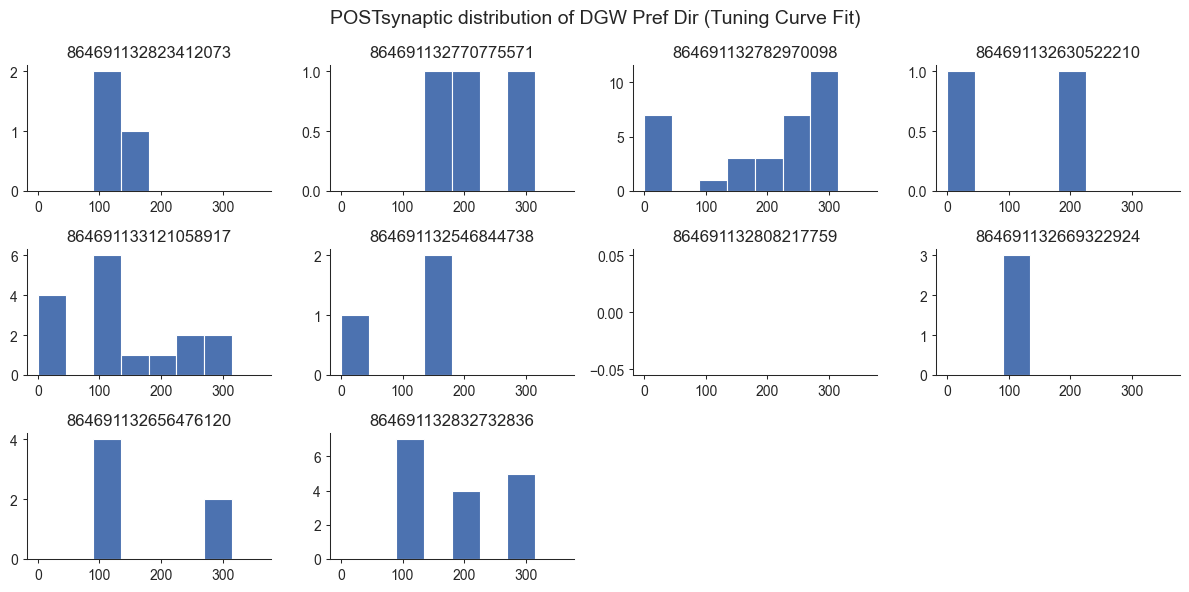

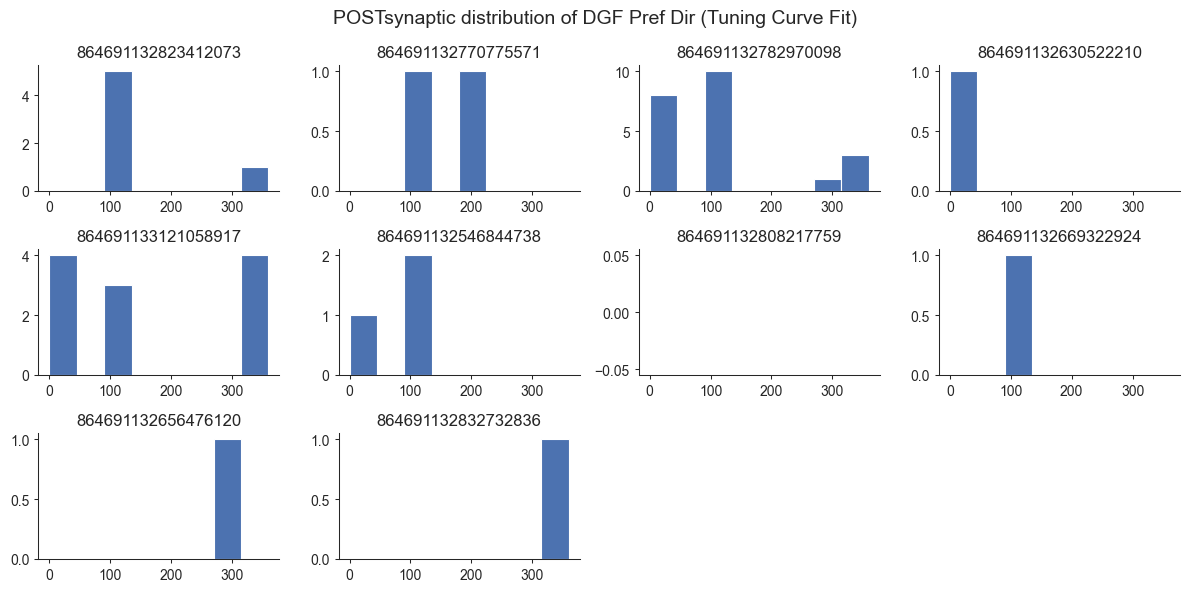

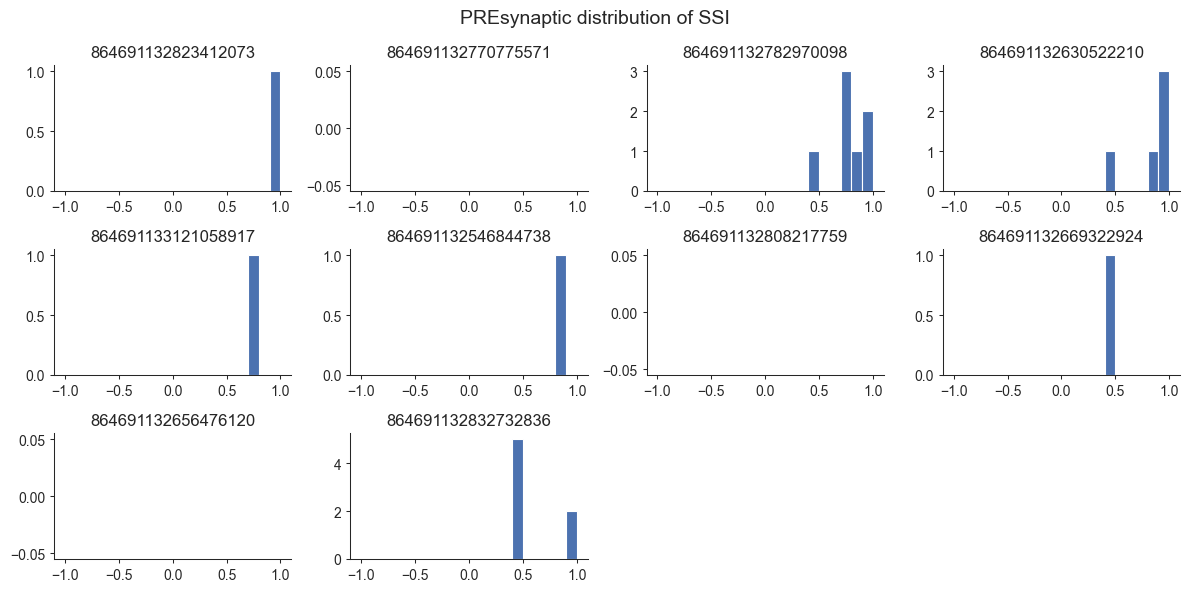

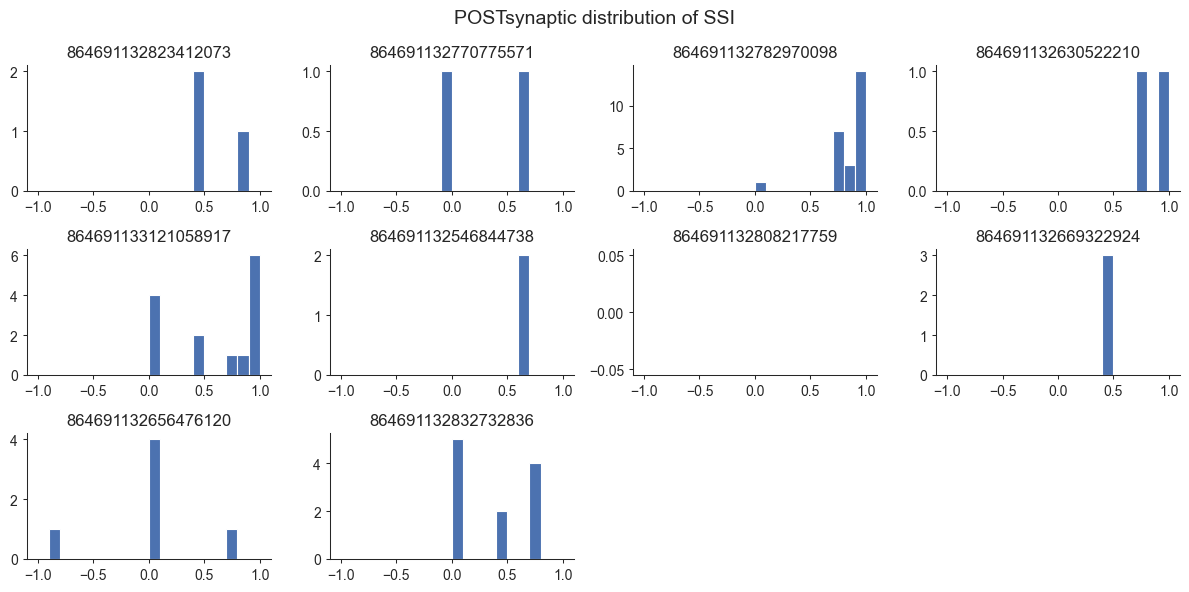

In [86]:
def plot_roi_counts(ax, den_syn, axo_syn, pre_met, post_met):
    bars = [
        ("pre", len(pre_met), "r"),
        ("pre-unq", len(pre_met.index.unique()), "r"),
        ("post", len(post_met), "b"),
        ("post-unq", len(post_met.index.unique()), "b"),
    ]
    bars2 = [
        ("pre-soma", np.mean(~den_syn.pre_soma_position.isna()), "g"),
        ("post-soma", np.mean(~axo_syn.post_soma_position.isna()), "g"),
    ]

    ax2 = ax.twinx()
    for a, b in (ax, bars), (ax2, bars2):
        a.bar([bb[0] for bb in b], [bb[1] for bb in b], color=[bb[2] for bb in b])
        ax.tick_params(axis="x", labelrotation=45)
    ax2.tick_params(axis="y", colors="g")  

dist_fn_euc = lambda this, other: np.sqrt(np.sum(np.square(this - other)))
dist_fn_horiz = lambda this, other: np.sqrt(np.sum(np.square(this[[0, 2]] - other[[0, 2]])))
dist_fn_vert = lambda this, other: other[1] - this[1] # e.g., +200 means other is 200 microns deeper than this

def plot_dist_soma(ax, syn, other_soma_key, dist_fn):
    syn_has_other_soma = syn.dropna(subset=other_soma_key)
    this_soma_key = "pre_soma_position" if other_soma_key == "post_soma_position" else "post_soma_position"
    soma_dists = syn_has_other_soma.apply(lambda row: dist_fn(row[this_soma_key], row[other_soma_key]), axis=1)
    # xmin, xmax = min(0, np.min(soma_dists)), np.max(soma_dists)
    xmin, xmax = 0, 700
    dist_range = np.arange(xmin, xmax+1, 1) # Steps of 1 micron
    frac_cells_within_dist = np.array([np.mean(soma_dists <= d) for d in dist_range])

    ax.plot(dist_range, frac_cells_within_dist)
    ax.axvspan(xmin=np.argmax(frac_cells_within_dist >= 0.25), xmax=np.argmax(frac_cells_within_dist >= 0.75), color="gray", alpha=0.4)
    ax.axvspan(xmin=np.argmax(frac_cells_within_dist >= 0.1), xmax=np.argmax(frac_cells_within_dist >= 0.9), color="gray", alpha=0.2)
    # ax.axvline(x=np.argmax(frac_cells_within_dist >= 0.9), color="purple", linestyle="dashed")
    ax.set_xlabel("$\mu$m", fontsize=10)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(0, ax.get_ylim()[1])
    ax.twinx().set_ylim(0, ax.get_ylim()[1] * len(soma_dists))

def plot_vert_dist_soma(ax, syn, other_soma_key):
    syn_has_other_soma = syn.dropna(subset=other_soma_key)
    this_soma_key = "pre_soma_position" if other_soma_key == "post_soma_position" else "post_soma_position"
    other_soma_vert_pos = syn_has_other_soma.apply(lambda row: row[other_soma_key][1], axis=1)
    this_soma_vert_pos = syn[this_soma_key].values[0][1] # since all values are the same
    xmin, xmax = 0, 800, # np.max(other_soma_vert_pos)
    dist_range = np.arange(xmin, xmax+1, 1) # Steps of 1 micron
    frac_cells_within_dist = np.array([np.mean(other_soma_vert_pos <= d) for d in dist_range])

    ax.axvline(x=this_soma_vert_pos, color="black", linestyle="dashed")
    ax.axvspan(xmin=np.argmax(frac_cells_within_dist >= 0.25), xmax=np.argmax(frac_cells_within_dist >= 0.75), color="gray", alpha=0.4)
    ax.axvspan(xmin=np.argmax(frac_cells_within_dist >= 0.1), xmax=np.argmax(frac_cells_within_dist >= 0.9), color="gray", alpha=0.2)
    ax.plot(dist_range, frac_cells_within_dist)
    ax.set_xlabel("Depth ($\mu$m)", fontsize=10)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(0, ax.get_ylim()[1])
    ax.twinx().set_ylim(0, ax.get_ylim()[1] * len(other_soma_vert_pos))

def scatter_soma_soma_dist_vs_syn_soma_dist(ax, syn, other_soma_key, dist_fn):
    # Scatter plot distance between pre- and postsynaptic somas (Y) vs. distance from synapse to postsynaptic soma (X)
    syn_has_other_soma = syn.dropna(subset=other_soma_key)
    mc_soma_key = "pre_soma_position" if other_soma_key == "post_soma_position" else "post_soma_position"
    syn_soma_dists = syn_has_other_soma.apply(lambda row: dist_fn_euc(row["position_microns"], row["post_soma_position"]), axis=1)
    soma_soma_dists = syn_has_other_soma.apply(lambda row: dist_fn(row[mc_soma_key], row[other_soma_key]), axis=1)

    at.density_scatter(x=syn_soma_dists, y=soma_soma_dists, ax=ax, xlabel="syn to postsyn-soma ($\mu$m)", ylabel="soma to soma ($\mu$m)", labelfontsize=10)

def scatter_syn_size_vs_syn_soma_dist(ax, syn, this_soma_key, dist_fn):
    syn_has_this_soma = syn.dropna(subset=this_soma_key)
    syn_sizes = syn_has_this_soma["size"]
    syn_soma_dists = syn_has_this_soma.apply(lambda row: dist_fn(row["position_microns"], row[this_soma_key]), axis=1)
    # syn_soma_dists = syn.apply(lambda row: dist_fn(row["position_microns"], row["post_soma_position"]), axis=1)
    at.density_scatter(x=syn_sizes, y=syn_soma_dists, ax=ax, xlabel="syn to MC-soma ($\mu$m)", ylabel="syn size", labelfontsize=10)

bins_pref_dir = np.arange(0, 360+45, 45)
bins_ssi = np.arange(-1, 1.1, 0.1)

plots = [
    # (
    #     "ROI counts for 2P-corresponded pre- and postsynaptic cells to each MC", 
    #     plot_roi_counts
    # ),
    # (
    #     "Fraction of PREsynaptic cells within a given EUCLIDEAN distance from MC",
    #     lambda ax, den_syn, axo_syn, pre_met, post_met: plot_dist_soma(ax, den_syn, "pre_soma_position", dist_fn_euc)
    # ),
    # (
    #     "Fraction of POSTsynaptic cells within a given EUCLIDEAN distance from MC",
    #     lambda ax, den_syn, axo_syn, pre_met, post_met: plot_dist_soma(ax, axo_syn, "post_soma_position", dist_fn_euc)
    # ),
    # (
    #     "Fraction of PREsynaptic cells within a given HORIZONTAL distance from MC",
    #     lambda ax, den_syn, axo_syn, pre_met, post_met: plot_dist_soma(ax, den_syn, "pre_soma_position", dist_fn_horiz)
    # ),
    # (
    #     "Fraction of POSTsynaptic cells within a given HORIZONTAL distance from MC",
    #     lambda ax, den_syn, axo_syn, pre_met, post_met: plot_dist_soma(ax, axo_syn, "post_soma_position", dist_fn_horiz)
    # ),
    # (
    #     "Fraction of PREsynaptic cells at different cortical depths",
    #     # lambda ax, den_syn, axo_syn, pre_met, post_met: plot_dist_soma(ax, den_syn, "pre_soma_position", dist_fn_vert)
    #     lambda ax, den_syn, axo_syn, pre_met, post_met: plot_vert_dist_soma(ax, den_syn, "pre_soma_position")
    # ),
    # (
    #     "Fraction of POSTsynaptic cells at different cortical depths",
    #     # lambda ax, den_syn, axo_syn, pre_met, post_met: plot_dist_soma(ax, axo_syn, "post_soma_position", dist_fn_vert)
    #     lambda ax, den_syn, axo_syn, pre_met, post_met: plot_vert_dist_soma(ax, axo_syn, "post_soma_position")
    # ),
    (
        "Horizontal distance between connected somas vs. Distance from MC DENDRITIC synapse to MC soma",
        lambda ax, den_syn, axo_syn, pre_met, post_met: scatter_soma_soma_dist_vs_syn_soma_dist(ax, den_syn, "pre_soma_position", dist_fn_horiz)
    ),
    (
        "Horizontal distance between connected somas vs. Distance from MC AXONAL synapse to POSTSYNAPTIC soma",
        lambda ax, den_syn, axo_syn, pre_met, post_met: scatter_soma_soma_dist_vs_syn_soma_dist(ax, axo_syn, "post_soma_position", dist_fn_horiz)
    ),
    (
        "DENDRITIC synapse size vs. Distance from DENDRITIC synapse to MC soma",
        lambda ax, den_syn, axo_syn, pre_met, post_met: scatter_syn_size_vs_syn_soma_dist(ax, den_syn, "post_soma_position", dist_fn_euc)
    ),
    (
        "AXONAL synapse size vs. Distance from AXONAL synapse to postsynaptic soma",
        lambda ax, den_syn, axo_syn, pre_met, post_met: scatter_syn_size_vs_syn_soma_dist(ax, axo_syn, "post_soma_position", dist_fn_euc)
    ),
    (
        "PREsynaptic distribution of DGW Pref Dir (Tuning Curve Fit)", 
        lambda ax, den_syn, axo_syn, pre_met, post_met: ax.hist(pre_met.dgw_pref_dir[pre_met.dgw_frac_responsive_trials >= 0.5], bins=bins_pref_dir)
    ),
    (
        "POSTsynaptic distribution of DGW Pref Dir (Tuning Curve Fit)", 
        lambda ax, den_syn, axo_syn, pre_met, post_met: ax.hist(post_met.dgw_pref_dir[post_met.dgw_frac_responsive_trials >= 0.5], bins=bins_pref_dir)
    ),
    (
        "POSTsynaptic distribution of DGF Pref Dir (Tuning Curve Fit)", 
        lambda ax, den_syn, axo_syn, pre_met, post_met: ax.hist(post_met.dgf_pref_dir[post_met.dgf_frac_responsive_trials >= 0.5], bins=bins_pref_dir)
    ),
    (
        "PREsynaptic distribution of SSI", 
        lambda ax, den_syn, axo_syn, pre_met, post_met: ax.hist(pre_met.ssi_fit[pre_met.dgw_frac_responsive_trials >= 0.5], bins=bins_ssi)
    ),
    (
        "POSTsynaptic distribution of SSI", 
        lambda ax, den_syn, axo_syn, pre_met, post_met: ax.hist(post_met.ssi_fit[post_met.dgw_frac_responsive_trials >= 0.5], bins=bins_ssi)
    ),
]

for fig_title, plotter in plots:
    fig, axs = plt.subplots(figsize=(12, 6), nrows=3, ncols=4)

    for i, ax in enumerate(axs.flat):
        if i >= len(mc_pt_root_ids):
            ax.axis("off")
            continue
        
        mc_pt_root_id = mc_pt_root_ids[i]
        ax.set_title(f"{mc_pt_root_id}")

        cell_den_syn = dendritic_synapses[dendritic_synapses.post_pt_root_id == mc_pt_root_id]
        cell_den_syn_has_ophys = cell_den_syn[cell_den_syn.pre_pt_root_id.isin(corresponded_table.pt_root_id)]
        presyn_rois = cell_den_syn_has_ophys.pre_pt_root_id.apply(lambda pt_root_id: corresponding_roi[pt_root_id])
        presyn_metrics = metrics.loc[roi_lookup_to_metrics_idx[presyn_rois].values]
        
        cell_axo_syn = axonal_synapses[axonal_synapses.pre_pt_root_id == mc_pt_root_id]
        cell_axo_syn_has_ophys = cell_axo_syn[cell_axo_syn.post_pt_root_id.isin(corresponded_table.pt_root_id)]
        postsyn_rois = cell_axo_syn_has_ophys.post_pt_root_id.apply(lambda pt_root_id: corresponding_roi[pt_root_id])
        postsyn_metrics = metrics.loc[roi_lookup_to_metrics_idx[postsyn_rois].values]
        
        plotter(ax, cell_den_syn, cell_axo_syn, presyn_metrics, postsyn_metrics)

    fig.suptitle(fig_title, fontsize=14)
    fig.tight_layout()

    # TODO: Shade background based on SSI? (do this for PCs)
